# House Prices: Advanced Regression Techniques, Part 2
----

## PCA, KMeans Clustering, and K Nearest Neighbors

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import display

%matplotlib inline 
pd.options.display.precision = 4
mpl.rcParams['font.family'] = 'Lato'
mpl.rcParams['font.weight'] = 700
sns.set(font='Lato', font_scale=1)
sns.set()
np.random.seed(42)

## Load the data from your `pickled` DataFrames

In [4]:
target = pd.read_pickle('pickled_target_df.p')
features = pd.read_pickle('pickled_feature_df.p')

## Use `LabelEncoder/OneHotEncoder` or `pd.get_dummies` to encode categorical variables

In [15]:
# Your code here:
feat_dummies = pd.get_dummies(features)

## Scale your data.

In [16]:
# Your code here:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(feat_dummies)

## Use the first two `PCA` components to visualize your data.

* Use your **target** as your color parameter.

In [17]:
# Your code here:
from sklearn.decomposition import PCA
pca = PCA()
feat_pca = pca.fit_transform(feat_scaled)

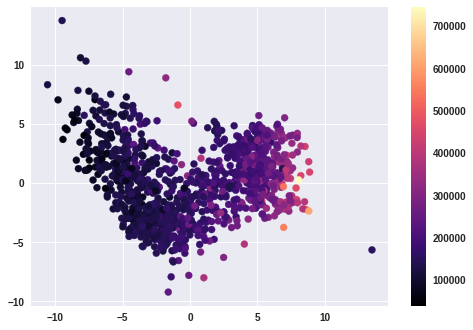

In [18]:
plt.scatter(feat_pca[:,0], feat_pca[:,1], c=target, cmap='magma')
plt.colorbar()

## Create a scree plot by plotting the explained variance and cumulative explained variance against component number.

In [19]:
# Your code here:
evr = pca.explained_variance_ratio_
x = list(range(len(evr)))

<Container object of 354 artists>

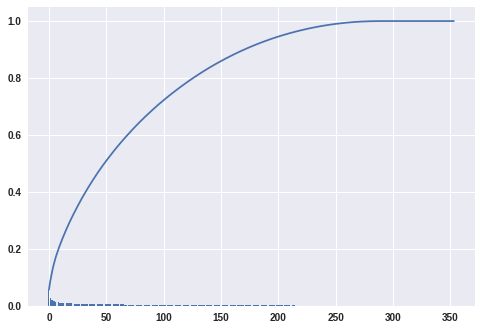

In [20]:
plt.plot(x, np.cumsum(evr))
plt.bar(x, evr)

## How many components do you need to explain 90% of your variance?

In [21]:
np.where(np.cumsum(pca.explained_variance_ratio_) > .9)[0][0]

171

## Use KMeans to cluster your data. Evaluate different values of K visually and with the silhouette score. Justify your choice.

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

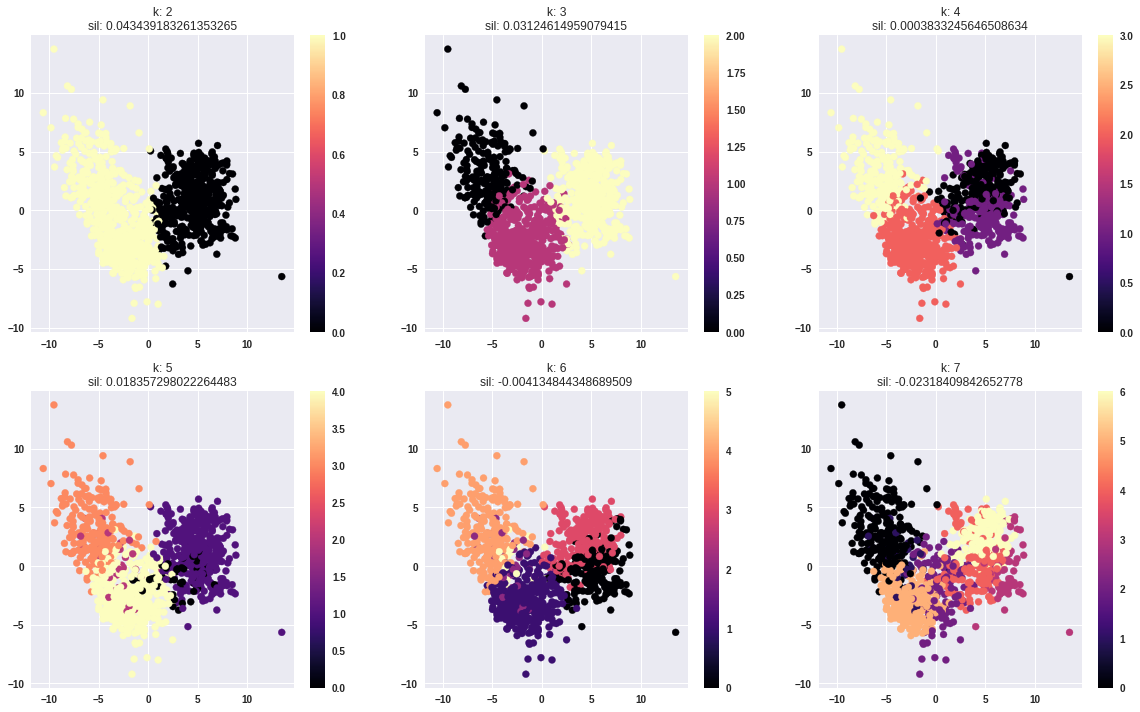

In [23]:
fig = plt.figure(figsize=(20,12))
for i, k in enumerate(range(2,8)):
    km = KMeans(n_clusters=k)
    km.fit(feat_scaled)
    sil = silhouette_score(feat_scaled, km.labels_)
    fig.add_subplot(2,3,1+i)
    plt.scatter(feat_pca[:,0],feat_pca[:,1], c=km.labels_, cmap='magma')
    plt.title('k: {}\nsil: {}'.format(k,sil))
    plt.colorbar()

In [24]:
# Although k=2 has the best silhouette score, let's use k=3. Visually, it looks like there are 3 clusters
# and the silhouette scores for k=2 and k=3 are not vastly different.

## Repeat the step above, excpt use `silhouette_samples` to make the color of each point its silhouette score. Which clusters are the best defined? Are there any that are more poorly defined?

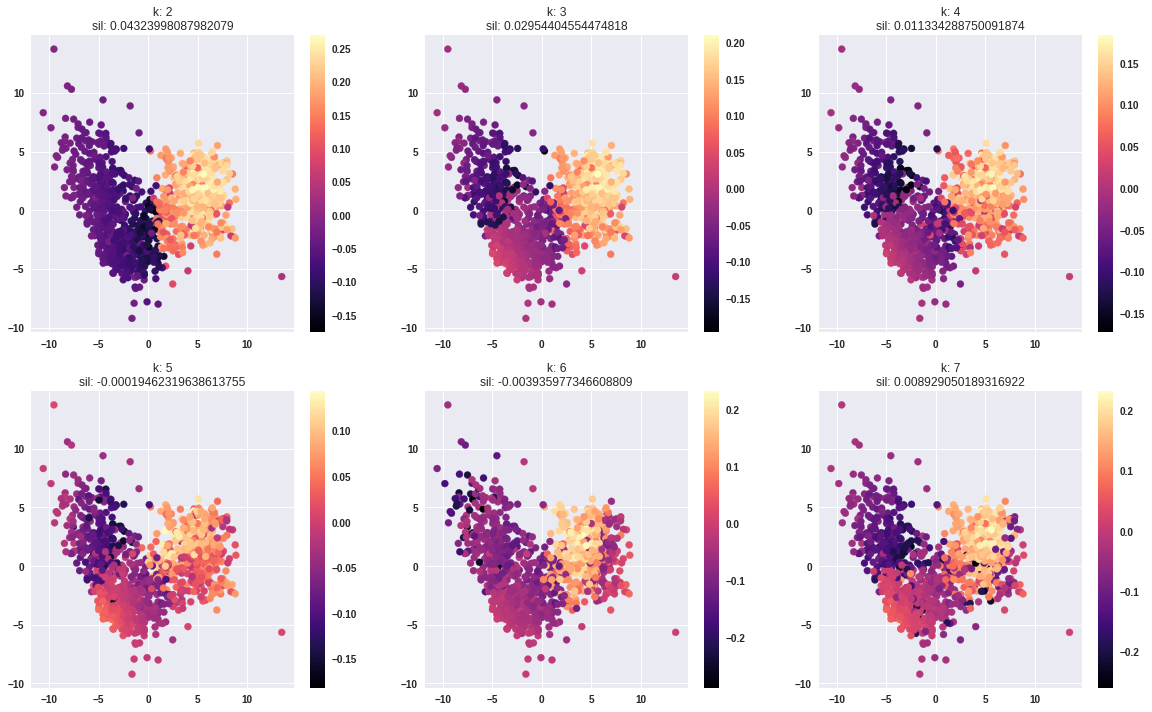

In [25]:
fig = plt.figure(figsize=(20,12))
for i, k in enumerate(range(2,8)):
    km = KMeans(n_clusters=k)
    km.fit(feat_scaled)
    sil = silhouette_score(feat_scaled, km.labels_)
    fig.add_subplot(2,3,1+i)
    plt.scatter(feat_pca[:,0],feat_pca[:,1],
                c=silhouette_samples(feat_scaled, km.labels_),
                cmap='magma')
    plt.title('k: {}\nsil: {}'.format(k,sil))
    plt.colorbar()

## Create a temporary target, `km_target`, from the `KMeans.labels_` from your KMeans clustering.

In [26]:
km = KMeans(n_clusters=3)
km.fit(feat_scaled)
km_target = km.labels_

## Use `KNeighborsClassifier` to build a model predicting your `km_target`. 

* Train test split your data
* Use GridSearchCV to cross-validate and find a good `n_neighbors` paramater.
* Evaluate your model performance using the `.score()` method, which returns accuracy.

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [28]:
X_train, X_test, y_train, y_test = train_test_split(feat_scaled,
                                                   km_target,
                                                   test_size = .3,
                                                   random_state = 42)

In [29]:
params = {
    'n_neighbors':list(range(1,21))
}

In [30]:
knc_gs = GridSearchCV(KNeighborsClassifier(),
                      param_grid=params,
                      cv=5)

In [31]:
knc_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
knc_gs.score(X_train,y_train)

0.94255874673629247

In [33]:
knc_gs.score(X_test,y_test)

0.90273556231003038

In [34]:
knc_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

## Plot your train and test scores from your `GridSearchCV.cv_results_` object over different values of k. Did this method yield a good value for k? 

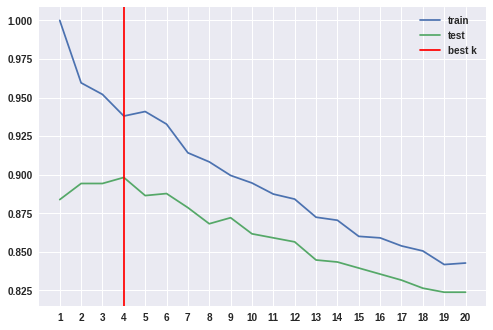

In [35]:
plt.plot(params['n_neighbors'], knc_gs.cv_results_['mean_train_score'],label='train')
plt.plot(params['n_neighbors'], knc_gs.cv_results_['mean_test_score'],label='test')
plt.xticks(params['n_neighbors'])
plt.axvline(knc_gs.best_estimator_.n_neighbors, label='best k', c='r')
plt.legend()

## Evaluate your model. Does it have high bias? High variance? How does GridSearchCV help reduce bias and variance?

# High bias ==> low train score (model unable to leaarn from data)

# High variance ==> low test score (model unable to generalize)

# Cross-validation helps us identify bias and variance by simulating multiple train-test splits and evaluating model on those splits

# Grid-search helps us reduce the bias and variance of our model by tuning hyperparamters without test data